In [1]:
import numpy as np
import os
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import model
import evaluation
import preprocess
from collections import defaultdict
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
import warnings
import tuning


warnings.filterwarnings("ignore")
%matplotlib inline

dict_best_estimators, dict_best_params, dict_scores = tuning.load_tuning_result()
X_train, X_test, y_train, y_test = preprocess.load_train_test()
ensemble_params = dict_best_params.copy()
ensemble_params['DecisionTree']['splitter'] = 'random'
ensemble_params['DecisionTree']['max_depth'] = 3

In [2]:
mds = []
model_num = {
    'DecisionTree': 15,
    'LR': 15,
    'SVM': 15,
    'XGBoost': 0
}
for md_name, md in tuning.models.items():
    params = dict_best_params[md_name]
    for i in range(model_num[md_name]):
        mds.append(md(**params))
       

In [3]:
params, scores, estimator = evaluation.best_param_search(
    estimator=model.MLPEnsemble(mds, (5,), activation='logistic'), params=[
            {'layers': [[10, 3], [20], [30]],},
        ], 
    X=X_train, y=y_train)

In [8]:
scores

,test_score,train_score,fit_time,score_time
"layers:[10, 3]",0.879912,0.888677,9.077716,0.874422
layers:[20],0.879912,0.888677,11.934035,0.834895
layers:[30],0.879912,0.888677,10.114473,0.754007


the recall for this model is : 0.876470588235


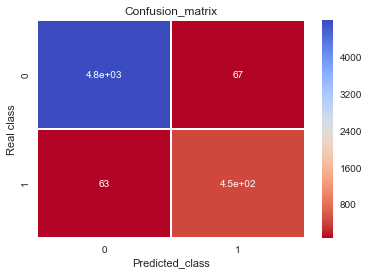


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      4860
          1       0.87      0.88      0.87       510

avg / total       0.98      0.98      0.98      5370

the recall for this model is : 0.898039215686


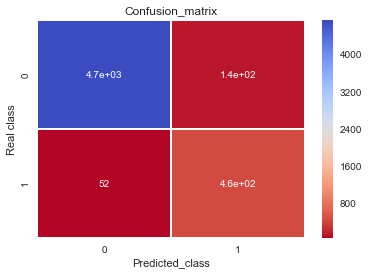


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      4860
          1       0.77      0.90      0.83       510

avg / total       0.97      0.96      0.97      5370

the recall for this model is : 0.905882352941


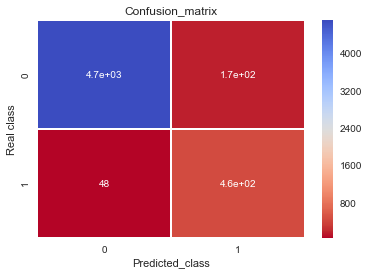


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.96      0.98      4860
          1       0.73      0.91      0.81       510

avg / total       0.97      0.96      0.96      5370



{'test': {'f1': 0.80839895013123364, 'roc_auc': 0.97868232066489147},
 'train': {'f1': 0.84476534296028871, 'roc_auc': 0.98677280519144883}}

In [4]:
sub_mds = [
    model.MLPEnsemble(mds, (15, 5), activation='logistic'),
    model.XGBoost(dict_best_params['XGBoost'])
]
evaluation.estimate(
    sub_mds[0],
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
evaluation.estimate(
    sub_mds[1],
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)
evaluation.estimate(
    model.LinearEnsemble(sub_mds),
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)

the recall for this model is : 0.911764705882


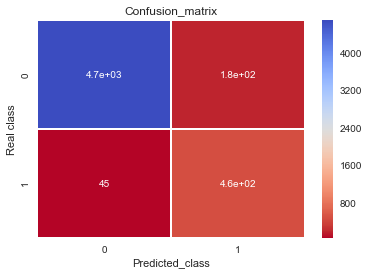


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.96      0.98      4860
          1       0.73      0.91      0.81       510

avg / total       0.97      0.96      0.96      5370



{'test': {'f1': 0.80869565217391315, 'roc_auc': 0.94803074316146219},
 'train': {'f1': 0.83592814371257484, 'roc_auc': 0.95901789591817732}}

In [5]:
evaluation.estimate(
    model.ProbaEnsemble(mds, model.SVM(C=1, kernel='linear')),
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)

the recall for this model is : 0.903921568627


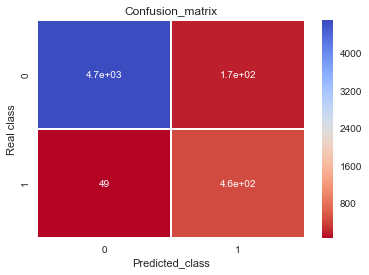


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.99      0.97      0.98      4860
          1       0.74      0.90      0.81       510

avg / total       0.97      0.96      0.96      5370



{'test': {'f1': 0.81090589270008806, 'roc_auc': 0.97343581053820705},
 'train': {'f1': 0.84008016032064137, 'roc_auc': 0.97611533527679584}}

In [6]:
evaluation.estimate(
    model.LinearEnsemble(mds, validation_rate=0.2),
    X_train, X_test, y_train, y_test,
    use_confusion_matrix=True
)

In [7]:
 
md = model.LinearEnsemble(learners=mds)
best_param, df_score, best_estimator_ = evaluation.best_param_search(
    estimator=md,
    params=[
        {'validation_rate': [0.1, 0.2, 0.3, 0.5], 'random_drop_rate': [0.2]}
    ],
    X=X_train,
    y=y_train
)